In [2]:
import os
import pandas as pd
import numpy as np
import sys
sys.path.append('/gpfs2/projects/project-bus_capstone_2016/workspace/mu529/Bus-Capstone')
import ttools #homemade module
import gtfs #homemade module
os.chdir('/gpfs2/projects/project-bus_capstone_2016/workspace/share')
%matplotlib inline

In [3]:
# get all the schedule data. (subset can be created later)
trips = gtfs.load_trips('gtfs/')
stops = gtfs.load_stops('gtfs/')
stop_times, tz_sched = gtfs.load_stop_times('gtfs/')
tcal = gtfs.TransitCalendar('gtfs/')
print 'Finished loading GTFS data.'

Finished loading GTFS data.


# get the sample of parsed AVL data.
Clean MTA prefixes from trip_id

In [4]:
# get the sample of parsed AVL data.  Beware, large files take more time.
bustime = pd.read_csv('newdata_parsed.csv')

In [7]:
bustime.columns = ['vehicle_id','route','timestamp','lat','lon','trip_id','trip_date','response']
bustime.drop_duplicates(['vehicle_id','timestamp'],inplace=True)
bustime['trip_id'] = bustime['trip_id'].str.replace('MTA NYCT_','')
bustime['trip_id'] = bustime['trip_id'].str.replace('MTABC_','')
bustime.set_index(['route','trip_id','trip_date','vehicle_id'],inplace=True,drop=True)

In [10]:
bustime.groupby(level=2).size()

trip_date
2016-06-12       2681
2016-06-13    3413467
2016-06-14    2372651
dtype: int64

In [11]:
# for demonstration, use a subset. Just get data for one trip-date.
tripDateLookup = "2016-06-13" # this is a non-holiday Monday
bustime = bustime.xs((tripDateLookup),level=(2),drop_level=False)
bustime.sort_index(inplace=True)
print 'Finished loading BusTime data and and slicing one day.'

Finished loading BusTime data and and slicing one day.


/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [12]:
# make a separate column with just the hour, to show distribution without parsing numerically
# bustime['timestamp_hour'] = bustime['timestamp'].str[11:13]
# bustime.groupby('timestamp_hour').size()

## Compare list of trip_id between GTFS schedule and BusTime reported data.
First just compare the length of the lists.

In [13]:
# Filter the service_ids for those applicable to this date
# gtfs.TransitCalendar class now correctly adjusts for exception dates
active_services = tcal.get_service_ids('2016-06-13') 
# Load a sepate trips dataframe but use only one index level
trips_ = gtfs.load_trips('gtfs/').reset_index().set_index(['service_id'])
# Generate list of all trip_ids that are scheduled for those service_ids
gtfs_trip_ids = trips_.loc[active_services]['trip_id'].unique()
# Generate list of all trip_ids in BusTime subset
bustime_trip_ids = bustime.index.get_level_values(1).unique()

In [14]:
len(gtfs_trip_ids)

54232

In [15]:
len(bustime_trip_ids)

52346

## Much smaller difference in trip lists using the recent sample
Return the non-matching trip_ids and describe a few things about those trips, based on the GTFS data.

In [16]:
# parse times into numeric
ts_parsed = bustime['timestamp'].apply(ttools.parseActualTime,tdate='2016-06-13')

### Plot distribution of BusTime pings throughout the day.  Look for sudden dips (gaps).

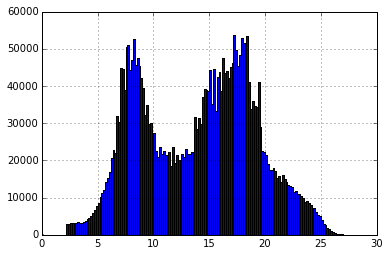

In [17]:
(ts_parsed/ttools.datetime.timedelta(hours=1)).hist(range=(0,30),bins=180)

The mid-day gap could be due to the schedule.  Peaks are clearly around rush-hours.
### Get the trip_id labels from GTFS which are not found anywhere in BusTime data

In [18]:
set1 = set(gtfs_trip_ids)
set2 = set(bustime_trip_ids)

unmatched = set1.symmetric_difference(set2) # goes both ways
len(unmatched)

1886

Show routes with percentage of trips missing any data

In [19]:
pct_missing_by_route = trips.loc[unmatched].groupby('route_id').size()/trips.groupby('route_id').size()
pct_missing_by_route.sort(ascending=False)
pct_missing_by_route

route_id
S84     0.062500
S92     0.055556
M79     0.044651
Q33     0.043689
Q42     0.042169
Q50     0.039370
QM10    0.038462
S56     0.037037
Q34     0.036145
M15     0.034836
BX23    0.033254
M101    0.030354
QM17    0.029412
BX4     0.028261
Q70     0.027778
Q49     0.027778
S89     0.027778
Q114    0.027132
BX21    0.026932
Q23     0.026928
S46     0.026398
B39     0.025862
Q67     0.025362
Q113    0.025352
BX18    0.025316
Q101    0.024887
Q19     0.024476
BX27    0.024476
Q18     0.024299
QM20    0.024194
          ...   
QM18         NaN
QM21         NaN
QM24         NaN
QM25         NaN
QM3          NaN
QM6          NaN
QM7          NaN
S54          NaN
S79+         NaN
S81          NaN
S86          NaN
S90          NaN
S91          NaN
S94          NaN
X10          NaN
X10B         NaN
X11          NaN
X14          NaN
X15          NaN
X21          NaN
X22A         NaN
X28          NaN
X3           NaN
X30          NaN
X31          NaN
X38          NaN
X42          NaN
X64  

### Show distribution of missing data according to the hour of service (based on stop times)
This should be roughly inverse to the data density plotted initially.

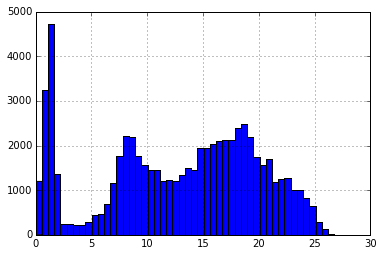

In [20]:
stop_hour = stop_times.reset_index().set_index('trip_id')['arrival_time'].apply(ttools.parseTime)/ttools.datetime.timedelta(hours=1)
stop_hour.loc[unmatched].hist(bins=48)

### Compare distributions of trip duration, all trips from GTFS versus the missing trips. 

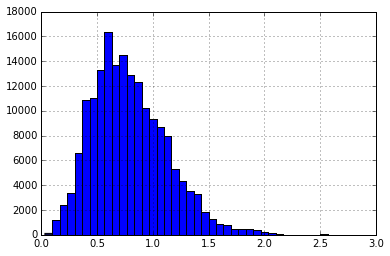

In [21]:
# Distribution of trip durations - ALL scheduled trips
pd.Series(stop_hour.groupby(level=0).max() - stop_hour.groupby(level=0).min()).hist(bins=40)

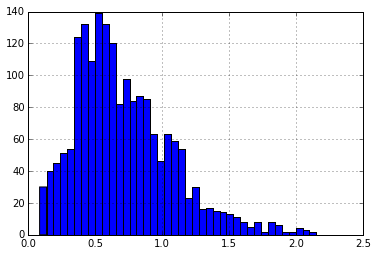

In [22]:
# Distribution of trip durations - MISSING trips only
pd.Series(stop_hour.loc[unmatched].groupby(level=0).max() - stop_hour.loc[unmatched].groupby(level=0).min()).hist(bins=40)

## Analyze expected trip data-density, but agnostic to trip_id
Plot a comparison (GTFS versus BusTime) of how many vehicles are on an active trip throughout the day.

In [23]:
start_bins = (10*stop_hour.loc[gtfs_trip_ids].groupby(level=0).min()).apply(np.floor).astype(int)
end_bins = (10*stop_hour.loc[gtfs_trip_ids].groupby(level=0).max()).apply(np.floor).astype(int)

In [24]:
# time is divided into bins of 0.1 hours (6 minutes)
# make a 2D binary matrix indicating when the trip is active during each time bin.
time_bin_matrix = np.zeros((len(start_bins),max(end_bins)+1))
counter = 0
for i,v_start in start_bins.iteritems():
    v_end = end_bins.loc[i]
    time_bin_matrix[counter,v_start:v_end] = 1
    counter += 1

Now do the same from the BusTime data.  Danger - vehicles may be recording data even when not on an active trip.

In [25]:
start_bins_bustime = (10*(ts_parsed.groupby(level=(1,3)).min()/ttools.datetime.timedelta(hours=1))).apply(np.floor).astype(int)
end_bins_bustime = (10*(ts_parsed.groupby(level=(1,3)).max()/ttools.datetime.timedelta(hours=1))).apply(np.floor).astype(int)
time_bin_matrix_bustime = np.zeros((len(start_bins_bustime),max(end_bins_bustime)+1))
counter = 0
for i,v_start in start_bins_bustime.iteritems():
    v_end = end_bins_bustime.loc[i]
    time_bin_matrix_bustime[counter,v_start:v_end] = 1
    counter += 1

### Plot the comparison.
Note that the BusTime data tracks the expected density nicely.

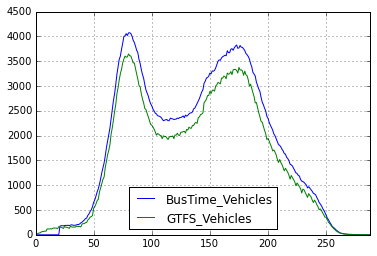

In [26]:
pd.DataFrame(time_bin_matrix_bustime.sum(axis=0),columns=['BusTime_Vehicles']).join(pd.Series(time_bin_matrix.sum(axis=0),name='GTFS_Vehicles')).plot()